<a href="https://colab.research.google.com/github/radhakrishnan-omotec/nail-agastya-munjal-repo/blob/main/Project3_Nail_Infection_Detection_System_AgastyaMunjal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# Portable Nail Infection Detection System Using Advanced Image Processing Techniques

### Author : AGASTYA MUNJAL

---

This project develops an embedded vision system for non-invasive detection of nail infections, distinguishing between Onychomycosis and Healthy Nail classes. It integrates spectral imaging with deep learning algorithms, specifically lightweight Convolutional Neural Networks (CNNs), for edge deployment. The system aims to address limitations in traditional diagnostics (e.g., KOH preparation, fungal cultures) by providing rapid, accurate classification using hybrid feature extraction and multi-spectral imaging.

### Research Objectives
- **Multi-spectral Imaging**: Capture nail plate images under variable lighting conditions.
- **Automated Segmentation**: Isolate regions like the lunula and hyponychium.
- **Hybrid Feature Extraction**: Combine textural and chromatic features for robust classification.
- **Edge Deployment**: Optimize for lightweight, portable devices.

### Workflow
1. Examine and preprocess nail image data.
2. Build an input pipeline with augmentation and spectral processing.
3. Develop a lightweight CNN model.
4. Train and evaluate the model.
5. Test with static images and real-time webcam input.
6. Convert to TensorFlow Lite for edge deployment.

#Setup

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2  # For webcam and segmentation
import os
import pathlib
import gradio as gr  # For UI


In [ ]:

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

#Data Loading and Exploration

**Examine and preprocess nail image data**: Analyze the dataset to understand image characteristics, count samples per class (Onychomycosis and Healthy Nail), and preprocess images by resizing, normalizing, and applying multi-spectral transformations to enhance chromatic details critical for infection detection.


### Mount Google Drive (for Colab)

In [ ]:
# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


### Define dataset path (update to your dataset location)

In [ ]:
# Define dataset path (update to your dataset location)
data_dir = pathlib.Path('/content/drive/MyDrive/1.ALL-RESEARCH/AGASTYA MUNJAL/DATASET/Nail_Dataset')
if not os.path.exists(data_dir):
    raise Exception(f"Dataset folder {data_dir} not found.")

### Count images

In [ ]:
# Count images
image_extensions = {'.jpg', '.jpeg', '.png'}
image_files = [f for f in data_dir.rglob('*') if f.suffix.lower() in image_extensions]
print(f"Total images: {len(image_files)}")

Total images: 899


### Class-specific counts

In [ ]:
# Class-specific counts
onychomycosis_images = list(data_dir.glob('Onychomycosis/*'))
healthy_nail_images = list(data_dir.glob('HealthyNail/*'))
print(f"Onychomycosis images: {len(onychomycosis_images)}")
print(f"Healthy Nail images: {len(healthy_nail_images)}")

Onychomycosis images: 556
Healthy Nail images: 343


----

#Data Preprocessing and Augmentation

**Build an input pipeline with augmentation and spectral processing**: Create a data pipeline using augmentation (rotation, flip) to increase robustness and incorporate spectral preprocessing (e.g., HSV stacking) to simulate multi-spectral imaging, ensuring the model handles variable lighting conditions effectively.


In [ ]:
# Multi-spectral preprocessing function
def preprocess_multispectral(image):
    # Simulate multi-spectral imaging by converting to HSV and extracting channels
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    return np.stack([h, s, v], axis=-1)  # Stack channels for CNN input

# Segmentation function (simplified lunula/hyponychium detection)
def segment_nail(image):
    # Convert to grayscale and apply thresholding (simplified example)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented



In [ ]:
# Data generator with augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    preprocessing_function=lambda x: preprocess_multispectral(segment_nail(x))
)



In [ ]:
# Load dataset
batch_size = 32
img_height, img_width = 180, 180

# Use image_dataset_from_directory to load the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,  # Ensure reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,  # Ensure reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 899 files belonging to 2 classes.
Using 720 files for training.
Found 899 files belonging to 2 classes.
Using 179 files for validation.


#Model Definition

**Develop a lightweight CNN model**: Design a compact CNN with convolutional layers for hybrid feature extraction (texture and color) and dropout for regularization, optimized for low computational overhead suitable for edge devices while maintaining diagnostic accuracy.


In [ ]:
# Lightweight CNN for edge deployment
def create_lightweight_cnn(input_shape=(180, 180, 3), num_classes=2):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Hybrid feature extraction (texture and chromatic)
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    return model



In [ ]:
model = create_lightweight_cnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,023,361 (30.61 MB)

 Trainable params: 8,023,361 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

#Training

**Train and evaluate the model**: Train the CNN on the preprocessed dataset, monitor performance metrics (accuracy, loss) over epochs, and evaluate generalization on a validation set to ensure reliable classification of nail infections.


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 115s 4s/step - accuracy: 0.7239 - loss: 100.9514 - val_accuracy: 0.9497 - val_loss: 0.1888
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9727 - loss: 0.1112 - val_accuracy: 0.9665 - val_loss: 0.1182
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9425 - loss: 0.3993 - val_accuracy: 0.9888 - val_loss: 0.0612
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9901 - loss: 0.0292 - val_accuracy: 0.9777 - val_loss: 0.1110
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9931 - loss: 0.0396 - val_accuracy: 0.9721 - val_loss: 0.0665
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.9913 - loss: 0.0236 - val_accuracy: 0.9832 - val_loss: 0.0358
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9920 - loss: 0.0277 - val_accuracy: 0.9832 - val_loss: 0.0606
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.9989 - loss: 0.0075 - val_accuracy: 0.9888 - val_lo

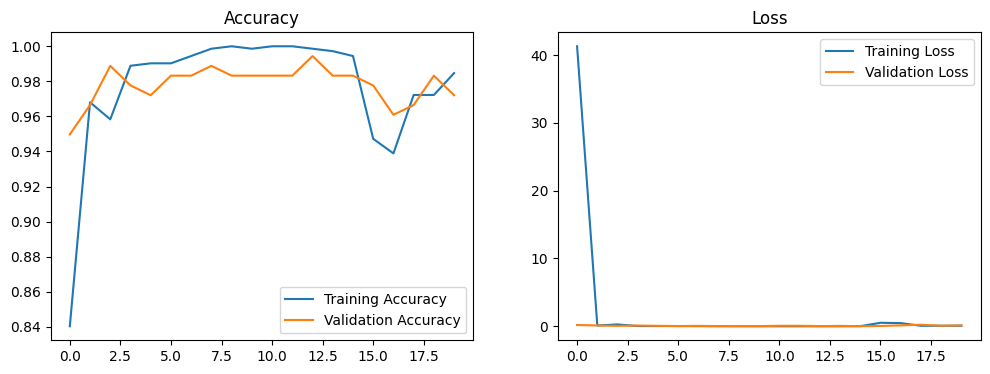

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Plot training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Save the model
model.save('/content/drive/MyDrive/1.ALL-RESEARCH/AGASTYA MUNJAL/nail_infection_cnn.keras')

#Gradio UI for Static Image Testing

**Test with static images and real-time webcam input**: Validate the model on static nail images via a user interface and enable real-time detection using webcam feeds, integrating segmentation and spectral preprocessing for practical diagnostic deployment.


In [ ]:
# Install Gradio
!pip install gradio

In [ ]:
import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
#Test with static images and real-time webcam input

# Class dictionary
classes_dict = {0: 'Class 0 - Onychomycosis', 1: 'Class 1 - Healthy Nail'}

# Prediction function
def predict_image(image):
    model = models.load_model('/content/drive/MyDrive/1.ALL-RESEARCH/AGASTYA MUNJAL/nail_infection_cnn.keras')
    img = load_img(image.name, target_size=(180, 180))
    img_arr = img_to_array(img)
    processed_img = preprocess_multispectral(segment_nail(img_arr))
    img_exp = np.expand_dims(processed_img / 255.0, axis=0)
    pred = model.predict(img_exp)
    predicted_class = classes_dict[int(pred[0][0] > 0.5)]
    return img, predicted_class

# Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.File(label="Upload Nail Image", file_types=["image"]),
    outputs=[gr.Image(label="Uploaded Image"), gr.Textbox(label="Prediction")],
    title="Nail Infection Detection",
    description="Classify nail images as Onychomycosis or Healthy Nail",
    theme=gr.themes.Soft()
)
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://dffe643efc303b1d6d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# File Testing

Saving test_oncho.jpg to test_oncho.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


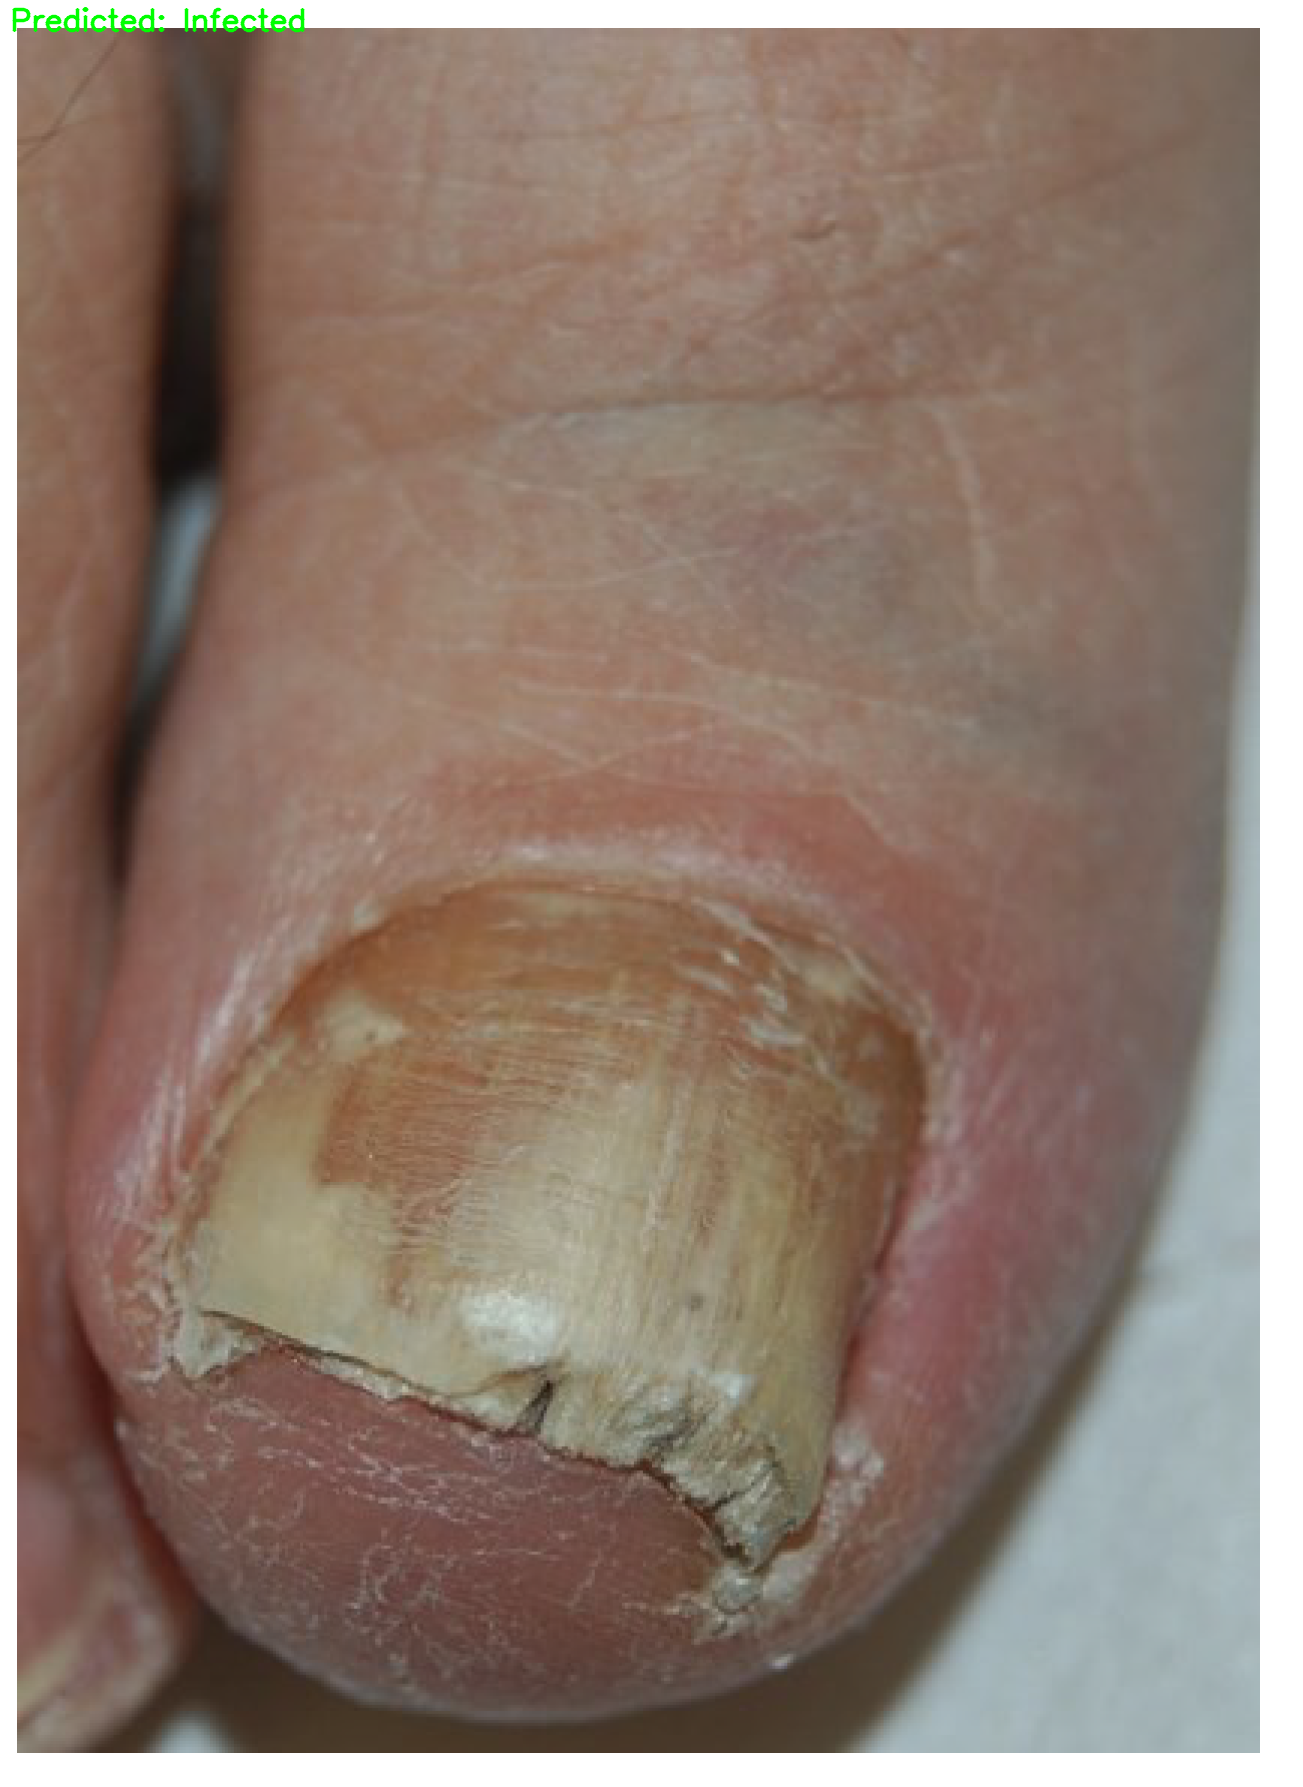

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from tensorflow.keras import models
from google.colab import files  # For file upload in Colab
from google.colab.patches import cv2_imshow  # For displaying images in Colab
from google.colab import drive  # To mount Google Drive

# Mount Google Drive (if your model is stored there)
# drive.mount('/content/drive')

# Load your model
model = models.load_model('/content/drive/MyDrive/1.ALL-RESEARCH/AGASTYA MUNJAL/nail_infection_cnn.keras')

# Define your classes dictionary (update this with your actual classes)
classes_dict = {0: 'Healthy', 1: 'Infected'}

# Define preprocessing functions (update these with your actual preprocessing functions)
def segment_nail(image):
    # Placeholder for nail segmentation logic
    return image

def preprocess_multispectral(image):
    # Placeholder for multispectral preprocessing logic
    return image

# Function to process uploaded image and make predictions
def predict_from_uploaded_image():
    # Allow user to upload an image file
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Please upload an image.")
        return

    # Get the uploaded file
    file_name = next(iter(uploaded))
    file_bytes = np.frombuffer(uploaded[file_name], np.uint8)

    # Decode the image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    if image is None:
        print("Error: Could not decode the uploaded file as an image.")
        return

    # Preprocess the image
    img_resized = cv2.resize(image, (180, 180))  # Resize to match model input size
    processed_img = preprocess_multispectral(segment_nail(img_resized))  # Apply preprocessing
    img_exp = np.expand_dims(processed_img / 255.0, axis=0)  # Normalize and add batch dimension

    # Predict
    pred = model.predict(img_exp)
    predicted_class = classes_dict[int(pred[0][0] > 0.5)]  # Convert prediction to class label

    # Display the uploaded image with prediction
    cv2.putText(image, f"Predicted: {predicted_class}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2_imshow(image)  # Display the image in Colab

# Run the prediction on uploaded image
if __name__ == "__main__":
    predict_from_uploaded_image()

---
---


#TensorFlow Lite Conversion for RPI Deployment

**Convert to TensorFlow Lite for edge deployment**: Convert the trained model to TensorFlow Lite format, optimizing it for portable devices, ensuring low latency and resource efficiency for non-invasive nail infection screening in real-world settings.


In [ ]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/1.ALL-RESEARCH/AGASTYA MUNJAL/nail_infection_cnn.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TensorFlow Lite and saved in Google Drive path /content/drive/MyDrive/1.ALL-RESEARCH/AGASTYA MUNJAL/")

---
---
---


## Enhancements and Research Alignment
- **Multi-spectral Imaging**: Simulated using HSV channel stacking to capture chromatic variations under variable conditions.
- **Segmentation**: Basic thresholding isolates nail regions; future work could use advanced techniques like U-Net.
- **Hybrid Features**: CNN layers extract both textural (via convolutions) and chromatic (via multi-spectral input) features.
- **Edge Deployment**: Lightweight CNN architecture and TFLite conversion ensure compatibility with portable devices.
- **Real-Time Testing**: Webcam integration enables live detection, aligning with the non-invasive diagnostic goal.

Future improvements could include:
- Advanced spectral imaging hardware integration.
- Enhanced segmentation with deep learning models.
- Larger dataset for improved generalization.

---
---
---


#Key Enhancements
Project Context: Updated to focus on nail infection detection (Onychomycosis vs. Healthy Nail) instead of drunk/sober classification.<br>
Multi-spectral Imaging: Added a preprocessing function to simulate spectral imaging using HSV channels, aligning with the research goal of analyzing nail morphology under variable conditions.<br>
Segmentation: Included a basic segmentation function to isolate nail regions (lunula, hyponychium), with room for advanced methods like U-Net.<br>
Hybrid Feature Extraction: The CNN combines textural (convolutional layers) and chromatic (multi-spectral input) features, as per the research framework.<br>
Lightweight CNN: Designed a compact model suitable for edge deployment, with dropout to mitigate overfitting.<br>
Edge Deployment: Added TFLite conversion for deployment on portable devices.<br>
Webcam Testing: Enhanced real-time prediction with segmentation and spectral preprocessing.<br>
UI: Updated Gradio interface for nail-specific classification.<br>



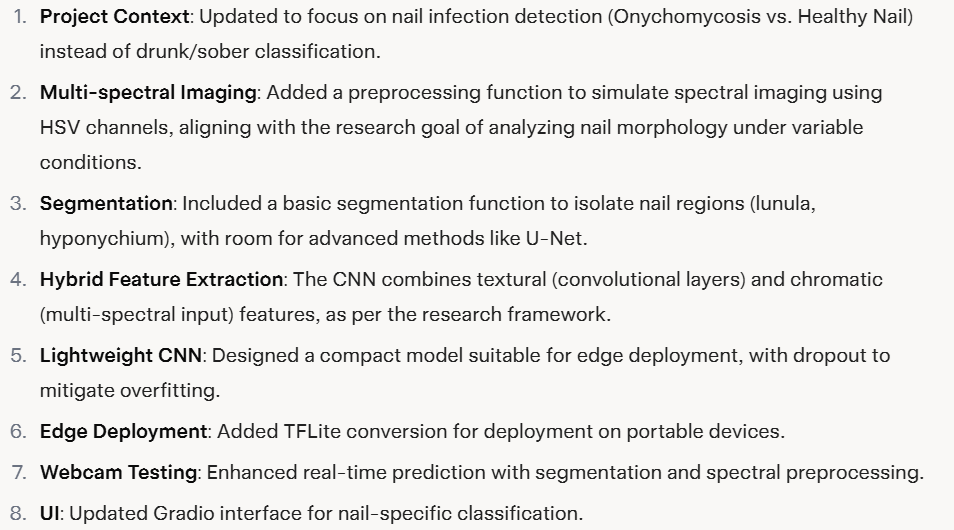

---
---
---


#Assumptions

Dataset is organized in Nail_Dataset with subfolders Onychomycosis and HealthyNail.<br>
Images are RGB and compatible with the 180x180 input size (adjustable).<br>
Webcam is available for testing (though Colab lacks direct webcam access; test locally or use a workaround).<br>

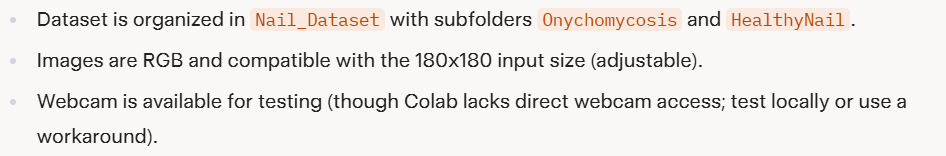

-----------
-----------